# PINNs to Solve Cyclic Voltammetry Problem
**Author**: Mahamat Azibert Abdelwahab

**Institution**: African Institut for Mathematical Science - Research and Innovation Centre

## Problem Setup

We will solve an inverse problem for ET systems for unknowns $D$ and $D^+$

$$
\begin{aligned}
    \partial_t C_Q - \partial_z(D\partial_z C_Q) &= 0, \quad && \quad (t, z) \in [0,2t_{\lambda}] \times [0, z_1],\\
   \partial_t C_{Q^+} - \partial_z(D^+\partial_z C_{Q^+}) &= 0, \quad &&\quad (t, z) \in [0,2t_{\lambda}] \times [0, z_1].
\end{aligned}
$$

Subject to the boundary conditions:

$$
\begin{aligned}
\partial_z C_{i}(t, z_1) &= 0, \quad \forall i \in {Q, Q^+} \quad && \quad \forall (t, z) \in [0,2t_{\lambda}] \times [0, z_1],\\
D\partial_z C_Q(t, 0)  &= K_f(t)C_Q(t, 0) - K_b(t)C_{Q^+}(t, 0), \quad && \quad \forall t \in [0,2t_{\lambda}], \\
D^+\partial_z C_{Q^+}(t, 0) &= -K_f(t)C_Q(t, 0) + K_b(t)C_{Q^+}(t, 0), \quad && \quad \forall t \in [0,2t_{\lambda}].
\end{aligned}
$$

And the initial condition:

$$
\begin{equation}
C_Q(0, z) = 1, \quad C_{Q^+}(0, z) = 0, \quad \quad \forall z\in [0,z_1].
\end{equation}
$$

Here $C_{i}(t,z)\in\mathbb{R}$ is the dimensionless concentration of the species $i\in \{\mathbf{Q},\mathbf{Q}^{+}\}$ and $D^+\in\mathbb{R}$ is the dimensionless diffusion of the specie $\mathbf{Q}^{+}$. The heterogeneous electron transfer rate constants, $k_b, k_f$, can  be written in its dimensionless form, $K_b, K_f$,  as follows:

$$
\begin{equation}
K_f = K_0\exp[(1-\delta)P], \quad \quad K_b = K_0\exp[(-\delta) P].
\end{equation}
$$

Where the dimensionless potential, $P$, in terms of the dimensionless time, is given by:

$$
\begin{align}
P = \left\lbrace
\begin{array}{ll}
P_1 + t , \; 0\leq t\leq t_\lambda\\
P_2 -  (t - t_\lambda) , \; t_\lambda\leq t\leq 2t_\lambda
\end{array} 
\right.,\qquad
t_\lambda = P_2-P_1,
\end{align}
$$

With $P_1$ and $P_2$ respectively the dimensionless initial and reverse potential. The dimensionless current, $G$, is given by:

$$
\begin{equation}
G(t) = \partial_zC_Q(t, 0)  = K_f(t)C_Q(t, 0) - K_b(t)C_{Q^+}(t, 0), \quad \forall t\in [0,2t_{\lambda}].
\end{equation}
$$

In [1]:
import scipy.io
import os
import numpy as np

data_folder = "/home/Elmustache/Documents/PINNs/ET_Model_PINNs/src/data/Synthetic Data"
result_folder = "/home/Elmustache/Documents/PINNs/Results"
image_folder = "/home/Elmustache/Documents/PINNs/Figure"


def read_data(D, K0):
    filename = f"Data_D_{D}_K0_{K0}.mat"
    filename_path = os.path.join(data_folder, filename)
    mat = scipy.io.loadmat(filename_path)

    T_span = mat["T_span"][0]
    Z_set = np.zeros_like(T_span)
    X = np.stack([Z_set, T_span], axis=1)
    G = mat["G"][0]
    pot = mat["pot"][0]
    K0 = mat["K0"][0,0]
    D = mat["D"][0,0]
    return D, K0, X, pot, G

In [2]:
# read_data(1, 10)

In [3]:
import deepxde as dde
import numpy as np
import tensorflow as tf


class ETModel:
    def __init__(self,
                 delta: float = 0.5,
                 D: float = 1.0,
                 D_plus: float = 1.0,
                 K0: float = 20,
                 P1: float = -10,
                 P2: float = 10
                ):
        # Set constants
        self.delta = delta  # Electron transfer coefficient
        self.D = D  # Ratio of diffusion coefficient of A
        self.D_plus = D_plus  # Ratio of diffusion coefficient of B
        self.K0 = K0  # Dimensionles electron transfer rate constant
        self.P1 = P1  # Starting dimensionless potential
        self.P2 = P2  # End dimensionless potential

        self.D_depth = 5 * (2 * np.pi * (P2 + 8)) ** 0.5
        self.t_lambda = P2 - P1

    def dimensionless_potential(self, t):
        p = np.where(t <= self.t_lambda, self.P1 + t, self.P2 - (t - self.t_lambda))
        return p

    def electron_transfer_rates(self, P):
        Kf = self.K0 * np.exp((1 - self.delta) * P)
        Kb = self.K0 * np.exp((-self.delta) * P)
        return Kf, Kb

    def pde(self, x, y):
        cq_t = dde.grad.jacobian(y, x, i=0, j=1)
        cq_zz = dde.grad.hessian(y, x, i=0, j=0)
        r = cq_t - cq_zz
        return r

    def coupled_pdes(self, x, y):
        cq_t = dde.grad.jacobian(y, x, i=0, j=1)
        cqp_t = dde.grad.jacobian(y, x, i=1, j=1)
        cq_zz = dde.grad.hessian(y, x, component=0, i=0, j=0)
        cqp_zz = dde.grad.hessian(y, x, component=1, i=0, j=0)

        eq1 = cq_t - self.D*cq_zz
        eq2 = cqp_t - self.D_plus * cqp_zz
        return [eq1, eq2]

    def boundary_left(self, x, on_boundary):
        return on_boundary and dde.utils.isclose(x[0], 0.0)

    def boundary_right(self, x, on_boundary):
        return on_boundary and dde.utils.isclose(x[0], self.D_depth)

    def boundary_left_t_0(self, x, on_boundary):
        return on_boundary and dde.utils.isclose(x[0], 0.0) and dde.utils.isclose(x[1], 0.0)

    def initial(self, x, on_initial):
        return on_initial and dde.utils.isclose(x[1], 0.0)
    
    def neumann_boundary_condition_cq(self, x):
        return 0.0

    def neumann_boundary_condition_cqp(self, x):
        return 0.0
    
    def robin_boundary_condition_cq(self, x, y):
        t = x[:, 1]
        cq = y[:, 0]
        cqp = y[:, 1]
        P = self.dimensionless_potential(t)
        k_f, k_b = self.electron_transfer_rates(P)
        r = (1.0 / self.D) * (k_f * cq - k_b * cqp)
        return r

    def robin_boundary_condition_cqp(self, x, y):
        t = x[:, 1]
        cq = y[:, 0]
        cqp = y[:, 1]
        P = self.dimensionless_potential(t)
        k_f, k_b = self.electron_transfer_rates(P)
        r = (1.0 / self.D_plus) * (-k_f * cq + k_b * cqp)
        return r

    def robin_boundary_condition(self, x, y):
        t = x[:, 1]
        P = self.dimensionless_potential(t)
        k_f, k_b = self.electron_transfer_rates(P)
        y = tf.reshape(y, shape=[-1])
        return (k_f + k_b)*y - k_b

    def robin_boundary_condition_combined(self, x, y, X):
        return dde.grad.jacobian(y, x, i=0, j=0) + dde.grad.jacobian(y, x, i=1, j=0)
    
    def dydx(self, x, y, X):
        return dde.grad.jacobian(y, x, i=0, j=0)

2024-09-12 17:04:37.994254: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-12 17:04:38.153075: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 17:04:38.238441: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 17:04:38.264016: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-12 17:04:38.385404: I tensorflow/core/platform/cpu_feature_guar

Instructions for updating:
non-resource variables are not supported in the long term


(401, 1)
Training - D = 1, D+ = 5, K0 = 5
+===========================================+
Compiling model...
Building feed-forward neural network...
'build' took 0.123891 s

'compile' took 1.226337 s

Training model...



2024-09-12 17:05:51.685565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [2.26e-03, 2.88e-03, 1.73e+00, 1.24e-02, 1.55e-04, 2.40e-05, 5.26e+03, 2.10e+02, 8.86e-03, 2.64e-02, 3.75e-03]    [1.15e-03, 1.33e-03, 1.73e+00, 1.24e-02, 1.55e-04, 2.40e-05, 5.26e+03, 2.10e+02, 8.86e-03, 2.64e-02, 3.75e-03]    []  
1000      [1.13e-03, 5.53e-04, 5.08e-02, 1.58e-03, 2.54e-05, 2.41e-06, 1.82e-02, 1.95e-03, 2.08e-03, 4.34e-04, 6.47e-04]    [1.11e-03, 5.03e-04, 5.08e-02, 1.58e-03, 2.54e-05, 2.41e-06, 1.82e-02, 1.95e-03, 2.08e-03, 4.34e-04, 6.47e-04]    []  
2000      [1.40e-03, 6.31e-04, 3.52e-02, 1.88e-03, 3.41e-05, 4.91e-06, 4.08e-03, 1.56e-03, 5.88e-04, 8.29e-06, 3.05e-04]    [1.32e-03, 6.44e-04, 3.52e-02, 1.88e-03, 3.41e-05, 4.91e-06, 4.08e-03, 1.56e-03, 5.88e-04, 8.29e-06, 3.05e-04]    []  
3000      [1.72e-03, 

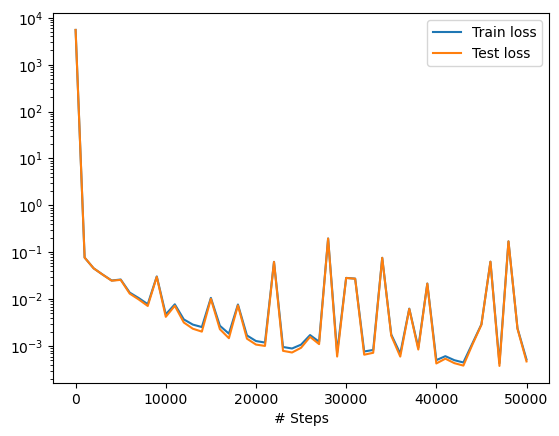

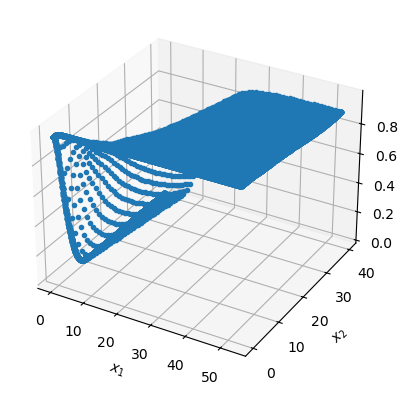

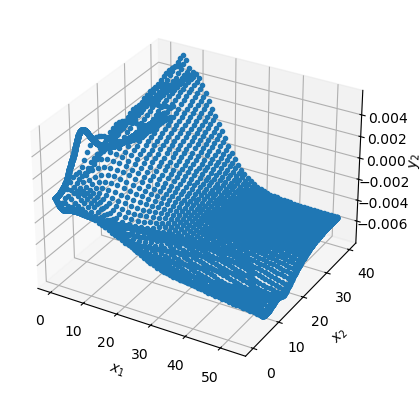

(401, 1)
Training - D = 1, D+ = 5, K0 = 10
+===========================================+
Compiling model...
Building feed-forward neural network...
'build' took 0.115265 s

'compile' took 1.457544 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [2.20e-03, 2.89e-03, 1.73e+00, 1.24e-02, 1.50e-04, 2.30e-05, 2.02e+04, 8.08e+02, 8.86e-03, 2.64e-02, 3.58e-03]    [1.15e-03, 1.33e-03, 1.73e+00, 1.24e-02, 1.50e-04, 2.30e-05, 2.02e+04, 8.08e+02, 8.86e-03, 2.64e-02, 3.58e-03]    []  
1000      [1.13e-03, 6.17e-04, 5.55e-02, 5.08e-03, 8.17e-05, 8.75e-06, 7.49e-02, 3.60e-03, 4.40e-03, 1.36e-03, 8.03e-04]    [1.11e-03, 5.73e-04, 5.55e-02, 5.08e-03, 8.17e-05, 8.75e-06, 7.49e-02, 3.60e-03, 4.40e-03, 1.36e-03, 8.03e-04]    []  
2000      [1.26e-03, 6.64e-04, 4.20e-02, 2.53

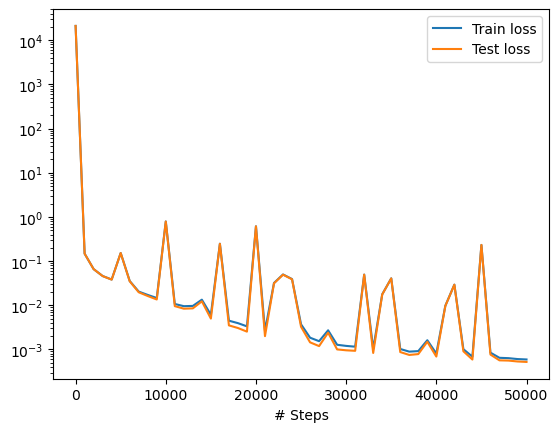

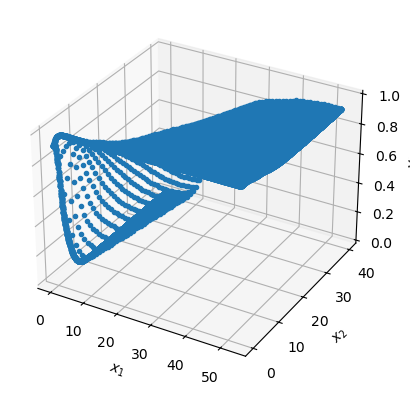

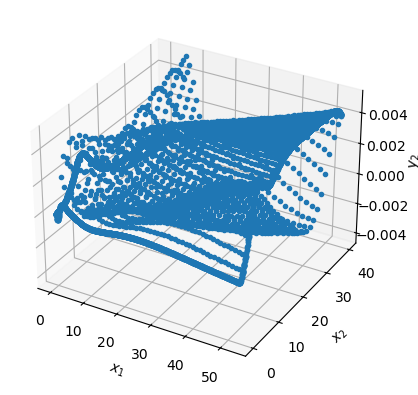

(401, 1)
Training - D = 1, D+ = 5, K0 = 20
+===========================================+
Compiling model...
Building feed-forward neural network...
'build' took 0.114087 s

'compile' took 1.409165 s

Training model...

Step      Train loss                                                                                                        Test loss                                                                                                         Test metric
0         [2.30e-03, 2.88e-03, 1.73e+00, 1.24e-02, 1.44e-04, 2.21e-05, 8.43e+04, 3.37e+03, 8.86e-03, 2.64e-02, 3.82e-03]    [1.15e-03, 1.33e-03, 1.73e+00, 1.24e-02, 1.44e-04, 2.21e-05, 8.43e+04, 3.37e+03, 8.86e-03, 2.64e-02, 3.82e-03]    []  
1000      [3.09e-03, 7.17e-04, 7.16e-02, 1.03e-02, 5.27e-04, 2.41e-05, 3.02e-01, 1.13e-02, 5.87e-03, 2.70e-03, 7.48e-04]    [3.33e-03, 6.58e-04, 7.16e-02, 1.03e-02, 5.27e-04, 2.41e-05, 3.02e-01, 1.13e-02, 5.87e-03, 2.70e-03, 7.48e-04]    []  
2000      [1.09e-03, 6.35e-04, 4.92e-02, 2.94

In [ ]:
import deepxde as dde
# from models.pinns_model import ETModel

D = 5
for K0 in (5, 10, 20):
    
    D, K0, X, P, G = read_data(D, K0)
    G = G.reshape(-1, 1)
    print(G.shape)

    print(f"Training - D = 1, D+ = {D}, K0 = {K0}")
    print("+===========================================+")
    et_model = ETModel(D_plus=D, K0=K0)
    geom = dde.geometry.Interval(0.0, et_model.D_depth)
    timedomain = dde.geometry.TimeDomain(0.0, 2 * et_model.t_lambda)
    geomtime = dde.geometry.GeometryXTime(geom, timedomain)
    
    # Define Boundary conditions
    initial_condition = dde.icbc.IC(geomtime, lambda x: 1.0, et_model.initial, component=0)
    neumann_bc = dde.icbc.NeumannBC(geomtime, lambda x: et_model.neumann_boundary_condition_cq(x), et_model.boundary_right, component=0)
    robin_bc = dde.icbc.RobinBC(geomtime, et_model.robin_boundary_condition_cq, et_model.boundary_left, component=0)
    robin_bc_0 = dde.icbc.RobinBC(geomtime, lambda x, y: 0.0, et_model.boundary_left_t_0, component=0)
    initial_condition_2 = dde.icbc.IC(geomtime, lambda x: 0.0, et_model.initial, component=1)
    neumann_bc_2 = dde.icbc.NeumannBC(geomtime, lambda x: et_model.neumann_boundary_condition_cqp(x), et_model.boundary_right, component=1)
    robin_bc_2 = dde.icbc.RobinBC(geomtime, et_model.robin_boundary_condition_cqp, et_model.boundary_left, component=1)
    robin_bc_2_1 = dde.icbc.RobinBC(geomtime, lambda x, y: 0.0, et_model.boundary_left_t_0, component=1)
    robin_bc_combined = dde.icbc.OperatorBC(geomtime, et_model.robin_boundary_condition_combined, et_model.boundary_left)
    
    # Define the PDE problem and configurations of the network:
    data = dde.data.TimePDE(
        geomtime,
        et_model.coupled_pdes,
        [initial_condition, initial_condition_2,
         neumann_bc, neumann_bc_2,
         robin_bc, robin_bc_2, robin_bc_0, robin_bc_2_1, robin_bc_combined
        ],
        num_domain=20000,
        anchors=X,
        num_boundary=1000,
        num_initial=1000,
        num_test=2000
    )
    
    
    layer_size = [2] + [20] * 3 + [7] * 3 + [2]
    activation = 'tanh'
    initializer = 'Glorot uniform'
    net = dde.nn.FNN(layer_size, activation, initializer)
    
    # loss_weights = [1, 1, 1, 1]
    # loss_weights = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    
    # Build the model:
    model = dde.Model(data, net)
    model.compile("adam", lr=1e-3)
    # model.compile("adam", lr=1e-3, loss_weights=loss_weights)
    
    checker = dde.callbacks.ModelCheckpoint(
        f"/home/Elmustache/Documents/PINNs/Results/saved_models/model_D_{D}_k0_{K0}.ckpt", save_better_only=True, period=10000, verbose=0
    )
    
    # Train Save the model
    losshistory, train_state = model.train(iterations=50000, callbacks=[checker])
    
    # save training the results
    dde.saveplot(losshistory,
                 train_state,
                 output_dir = f"/home/Elmustache/Documents/PINNs/Results/saved_models/model_D_{D}_k0_{K0}_training_files",
                 issave=True,
                 isplot=True)

    
